In [6]:
import os
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

train_dir='../dataset/cats_and_dogs_small/train'
validation_dir='../dataset/cats_and_dogs_small/validation'
test_dir='../dataset/cats_and_dogs_small/test'

train_cats_dir= os.path.join(train_dir,'cats')
train_dogs_dir=os.path.join(train_dir,'dogs')
validation_cats_dir=os.path.join(validation_dir,'cats')
validation_dogs_dir=os.path.join(validation_dir,'dogs')
test_cats_dir= os.path.join(test_dir,'cats')
test_dogs_dir= os.path.join(test_dir,'dogs')

print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))
print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

# parameter
batch_size=20
learning_rate=0.0001
epochs=30


1 Physical GPUs, 1 Logical GPUs
훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


In [7]:

### data
## DATA를 만듬
argu_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2, ## 가로로 이동 비율
                                    height_shift_range=0.2,  ## 세로로 이동 비율
                                    shear_range=0.2,  # 전단의 강도
                                    zoom_range=0.2, ## 확대 와 축소 범위 [1-0.2 ~ 1+0.2 ]
                                    horizontal_flip=True)  ## 수평기준 플립

#valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
#test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)


In [8]:

## 만든데이터를 불러와서 파씽함.
train_generator = argu_train_datagen.flow_from_directory(
        directory=train_dir,         # 타깃 디렉터리
        target_size=(128, 128),      # 모든 이미지를 150 × 150 크기로 바꿉니다
        batch_size=batch_size,
        interpolation='bilinear',  ## resize시 interpolatrion 기법
        color_mode ='rgb',
        shuffle='True',
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary') # binary, categorical , sparse , input

## class의 인덱스를 확인.
print(train_generator.class_indices)
print(train_generator.classes)

#validation_generator = valid_datagen.flow_from_directory(
#        directory=validation_dir,
#        target_size=(128, 128),
#        batch_size=batch_size,
#        shuffle='True',
#        interpolation='bilinear',  ## resize시 interpolatrion 기법
#        color_mode='rgb',
#        class_mode='binary') #categorical
#
#test_generator = test_datagen.flow_from_directory(
#        directory=validation_dir,
#        target_size=(128, 128),
#        batch_size=batch_size,
#        shuffle='True',
#        interpolation='bilinear',  ## resize시 interpolatrion 기법
#        color_mode='rgb',
#        class_mode='binary') #categorical
#
### 파씽한 데이터의 배치사이즈 확인하기
#for data_batch, labels_batch in train_generator:
#    print('배치 데이터 크기:', data_batch.shape)
#    print('배치 레이블 크기:', labels_batch.shape)
#    print('class :',train_generator.class_indices)
#    break

validation_generator = test_datagen.flow_from_directory(
        directory=test_dir,         # 타깃 디렉터리
        target_size=(128, 128),      # 모든 이미지를 150 × 150 크기로 바꿉니다
        batch_size=batch_size,
        interpolation='bilinear',   ## resize시 interpolatrion 기법
        color_mode ='rgb',
        shuffle='True',
        class_mode='binary',  # categorical , sparse , input
        subset='validation')  # ImageDataGenerator 옵션에서  validation_split=0.2 만큼 validataion data 생성

print(train_generator.class_indices)
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        shuffle='True',
        interpolation='bilinear',  ## resize시 interpolatrion 기법
        color_mode='rgb',
        class_mode='binary', #categorical
        subset='training') # ImageDataGenerator 옵션에서  validation_split=0.2 기준을 뺀 0.8만큼 test data 생성

for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
[0 0 0 ... 1 1 1]
Found 200 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
Found 800 images belonging to 2 classes.
배치 데이터 크기: (20, 128, 128, 3)
배치 레이블 크기: (20,)


In [9]:


## 모델
input_Layer = tf.keras.layers.Input(shape=(128,128,3))
x=tf.keras.layers.Conv2D(32,(3,3),strides=1, activation='relu')(input_Layer)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),strides=1,activation='relu')(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),strides=1,activation='relu')(x)
x=tf.keras.layers.Conv2D(128,(3,3),strides=1,activation='relu')(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
x= tf.keras.layers.Dense(512, activation='relu')(x)
Out_Layer= tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 128)       1475

In [10]:

loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=learning_rate)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir')]

## generator는 입력과 타깃의 배치를 끝없이 반환한다.
## 데이터가 끝없이 생성되기 때문에 모델에 하나의 에포크를 정의할때 제너레이터로부터 얼만큼 많은 샘플을 뽑을지 전달해야함
## steps_pr_epoch 가 100이면 위에서 선언된 배치 수만큼의 인풋/아웃풋데이터가 생성되어 학습이 된다.
##즉, 배치가 20이면 20의 배치인 데이터가 100번만큼 생성되어 학습한다. 즉, 20의 배치 데이터를 100번 학습완료하면 1에포크
## 단, 20의 배치데이터를 생성할때마다 랜덤적으로 생성한다.
## 일반적으로 배치사이즈/전체 데이터 길이를 steps_per_epoch로 설정한다.
result = model.fit(
      train_generator,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=5,
      validation_data=validation_generator,
      # callbacks=callbacks_list,
      validation_freq=1
)
print(model.evaluate(test_generator))
model.save('cats_and_dogs_aug_binary_classification.hdf5')


Epoch 1/5
100/100 [==============================] - 17s 164ms/step - loss: 4.3937 - binary_accuracy: 0.5345 - val_loss: 0.7721 - val_binary_accuracy: 0.5150
Epoch 2/5
100/100 [==============================] - 16s 162ms/step - loss: 0.7004 - binary_accuracy: 0.5635 - val_loss: 0.6889 - val_binary_accuracy: 0.5550
Epoch 3/5
100/100 [==============================] - 16s 160ms/step - loss: 0.6646 - binary_accuracy: 0.5980 - val_loss: 0.6813 - val_binary_accuracy: 0.6100
Epoch 4/5
100/100 [==============================] - 16s 161ms/step - loss: 0.6699 - binary_accuracy: 0.5885 - val_loss: 0.6314 - val_binary_accuracy: 0.6200
Epoch 5/5
40/40 [==============================] - 3s 82ms/step - loss: 0.6434 - binary_accuracy: 0.6237
[0.6433895826339722, 0.6237499713897705]


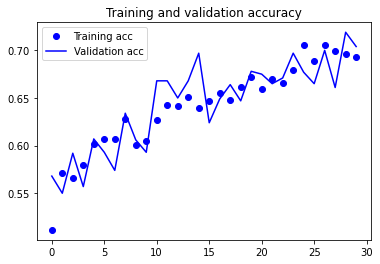

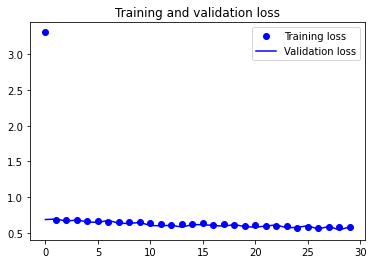

In [7]:

import matplotlib.pyplot as plt

acc = result.history['binary_accuracy']
val_acc = result.history['val_binary_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()